# Gradient Boosting: XGBoost vs LightGBM
#### Master's Level Practical Implementation

In this notebook, we explore gradient boosting methods using two popular libraries: **XGBoost** and **LightGBM**. We use the California Housing dataset as a case study and compare these models against baseline approaches such as linear regression and random forests. 

Topics:
- An introduction to gradient boosting fundamentals
- Data preparation, EDA, and preprocessing
- Baseline models for context
- Implementation of XGBoost and LightGBM (including early stopping)
- Advanced hyperparameter tuning with Optuna
- Model interpretation using SHAP values
- Concluding Remarks

## 0. Install and Import Required Libraries
We first install and import the necessary packages. In addition to the basic libraries, we will use **Optuna** for hyperparameter tuning, and **SHAP** for model interpretation.

In [ ]:
# Uncomment if running in a new environment
#!pip install xgboost lightgbm scikit-learn pandas matplotlib optuna shap --quiet

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
import lightgbm as lgb

import optuna
import shap

%matplotlib inline
plt.style.use('seaborn-v0_8-bright')

/mnt/c/Users/xamani/tf-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. An introduction to gradient boosting fundamentals

Gradient boosting is an ensemble learning technique that builds a strong predictive model by sequentially combining a series of weak learners—typically decision trees. Unlike methods that build models independently (e.g., bagging used in Random Forests), gradient boosting constructs models one after the other, with each new model focusing on correcting the errors made by its predecessors.

## How Does Gradient Boosting Work?

At its core, gradient boosting minimizes a specified loss function by iteratively adding models that point in the direction of the steepest descent—i.e., the negative gradient of the loss with respect to the current model's predictions. Here’s a step-by-step breakdown:

1. **Initialization:**  
   Start with a simple model. For regression tasks, this is often a constant value (like the mean of the target variable) that minimizes the loss function.

2. **Iterative Refinement:**
   - **Compute Residuals:**  
     For each data point, calculate the residuals (or pseudo-residuals), which represent the difference between the actual target values and the current predictions.
   - **Fit a Weak Learner:**  
     Train a simple model (usually a shallow decision tree) to predict these residuals.
   - **Update the Ensemble:**  
     Add the new model to the ensemble. The overall prediction is updated by combining the previous prediction with a scaled version of the new model's output. The scaling factor, known as the *learning rate* (\(\nu\)), controls how much influence the new model has:
     $$
     F_m(x) = F_{m-1}(x) + \nu \cdot h_m(x)
     $$
     where:
     - $F_{m-1}(x)$ is the current ensemble prediction,
     - $h_m(x)$ is the new weak learner,
     - $\nu$ is the learning rate.

3. **Final Prediction:**  
   After repeating the process for a pre-determined number of iterations (or until performance converges), the final model is a weighted sum of all the weak learners.

## Key Intuitions Behind Gradient Boosting

- **Sequential Learning:**  
  Each new model is built specifically to address the shortcomings of the current ensemble. This means that the method continuously refines its predictions, focusing on the examples that are hardest to predict.

- **Gradient Descent in Function Space:**  
  Instead of optimizing parameters directly, gradient boosting performs a form of gradient descent in the space of functions. Each weak learner approximates the negative gradient of the loss function, effectively steering the model towards a better fit.

- **Bias-Variance Trade-off:**  
  - **Bias Reduction:** By adding models that correct for previous errors, the ensemble can capture more complex patterns, reducing bias.
  - **Variance Control:** The learning rate and the complexity of the individual trees (depth, number of leaves) are tuned to avoid overfitting, thus managing variance.


- **Flexibility in Loss Functions:**  
  One of the strengths of gradient boosting is its adaptability. Whether you are solving a regression, classification, or even ranking problem, you can tailor the approach by choosing an appropriate loss function.

## Why Use Gradient Boosting?

Gradient boosting has become a cornerstone in modern machine learning for several reasons:

- **High Predictive Performance:**  
  It often outperforms simpler models by effectively capturing complex, non-linear relationships in the data.

- **Versatility:**  
  With the ability to switch loss functions and fine-tune numerous hyperparameters (like learning rate, tree depth, and number of iterations), gradient boosting can be adapted to a wide range of tasks.

- **Robust Implementations:**  
  Libraries such as XGBoost and LightGBM offer highly optimized implementations that not only speed up training but also include advanced features (e.g., handling missing values, early stopping) to make the models more robust.

## 2. Data Preparation and Exploratory Data Analysis (EDA)
We will use the California Housing dataset from scikit-learn. Let's load the data and perform a quick EDA.

In [2]:
# Load dataset
california = fetch_california_housing()
data = pd.DataFrame(california.data, columns=california.feature_names)
data['MedHouseVal'] = california.target

# dataset info
print(f"Dataset shape: {data.shape}")
display(data.head())

# Basic stats
display(data.describe())

Dataset shape: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


## 3. Data Preprocessing
We split the dataset into training and test sets. Although tree-based models typically do not require feature scaling, proper splitting is essential for evaluation.

In [3]:
X = data.drop('MedHouseVal', axis=1)
y = data['MedHouseVal']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (16512, 8)
Test set shape: (4128, 8)


## 4. Baseline Models
Before diving into gradient boosting, we compare two baseline models: **Linear Regression** and **Random Forest Regression**. This will provide context on when boosting might be beneficial.

In [4]:
# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_pred = lin_reg.predict(X_test)

# Random Forest Regression
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)
rf_pred = rf_reg.predict(X_test)

def evaluate_model(name, y_true, y_pred):
    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R²': r2_score(y_true, y_pred)
    }
    print(f"{name} Performance:")
    for k, v in metrics.items():
        print(f"  {k}: {v:.4f}")
    print("\n")
    return metrics

print("Baseline Models:\n")
lin_metrics = evaluate_model("Linear Regression", y_test, lin_pred)
rf_metrics = evaluate_model("Random Forest", y_test, rf_pred)

Baseline Models:

Linear Regression Performance:
  MAE: 0.5332
  RMSE: 0.7456
  R²: 0.5758


Random Forest Performance:
  MAE: 0.3275
  RMSE: 0.5053
  R²: 0.8051




## 5. XGBoost Implementation with Early Stopping
Here we set up an XGBoost regressor with key configuration parameters. Notice that we use **early stopping** by monitoring the evaluation metric on the test set. This helps prevent overfitting.

In [6]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.1,
    max_depth=6,
    n_estimators=1000,  # set high and let early stopping decide
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42, early_stopping_rounds = 50
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

xgb_pred = xgb_model.predict(X_test)
xgb_metrics = evaluate_model("XGBoost", y_test, xgb_pred)

XGBoost Performance:
  MAE: 0.2868
  RMSE: 0.4392
  R²: 0.8528




## 6. LightGBM Implementation with Early Stopping
Similarly, we set up a LightGBM regressor. LightGBM is particularly efficient on larger datasets and supports native categorical features.

We again use early stopping by providing an evaluation set.

In [8]:
lgb_model = lgb.LGBMRegressor(
    objective='regression',
    learning_rate=0.1,
    num_leaves=63,
    n_estimators=1000,  # high number with early stopping
    feature_fraction=0.8,
    bagging_fraction=0.8,
    random_state=42,
    early_stopping_rounds=50
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)])

lgb_pred = lgb_model.predict(X_test)
lgb_metrics = evaluate_model("LightGBM", y_test, lgb_pred)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current 

## 7. Advanced Hyperparameter Tuning with Optuna
Optuna is a powerful hyperparameter optimization framework. In the cell below, we define an objective function to tune key XGBoost hyperparameters. 

For a real-world scenario, you may wish to tune more parameters or use cross-validation for a robust assessment.

In [12]:
def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'n_estimators': 500
    }
    
    # Use cross-validation to evaluate performance
    model = xgb.XGBRegressor(**param, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
    rmse = np.mean(np.sqrt(-scores))
    return rmse

# This may take a few minutes depending on the n_trials
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20, show_progress_bar=True)

print("Best trial:")
trial = study.best_trial
print(f"  RMSE: {trial.value:.4f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-02-10 13:12:30,768] A new study created in memory with name: no-name-0c800daa-4404-49ef-a641-2dfc6730b636
Best trial: 0. Best value: 0.462381:   5%|██▎                                            | 1/20 [00:01<00:24,  1.29s/it]

[I 2025-02-10 13:12:32,057] Trial 0 finished with value: 0.46238129116383636 and parameters: {'learning_rate': 0.05719123395891358, 'max_depth': 6, 'subsample': 0.6267359987088625, 'colsample_bytree': 0.5255488636536083}. Best is trial 0 with value: 0.46238129116383636.


Best trial: 0. Best value: 0.462381:  10%|████▋                                          | 2/20 [00:02<00:22,  1.25s/it]

[I 2025-02-10 13:12:33,287] Trial 1 finished with value: 0.46708025371364553 and parameters: {'learning_rate': 0.07881765699236952, 'max_depth': 5, 'subsample': 0.7099404922632955, 'colsample_bytree': 0.5257339478787157}. Best is trial 0 with value: 0.46238129116383636.


Best trial: 0. Best value: 0.462381:  15%|███████                                        | 3/20 [00:03<00:17,  1.01s/it]

[I 2025-02-10 13:12:34,007] Trial 2 finished with value: 0.48483950691590394 and parameters: {'learning_rate': 0.08138866235201081, 'max_depth': 3, 'subsample': 0.7552216935085302, 'colsample_bytree': 0.9339463032907189}. Best is trial 0 with value: 0.46238129116383636.


Best trial: 3. Best value: 0.4566:  20%|█████████▊                                       | 4/20 [00:04<00:16,  1.05s/it]

[I 2025-02-10 13:12:35,119] Trial 3 finished with value: 0.456599766616886 and parameters: {'learning_rate': 0.05181865547922671, 'max_depth': 6, 'subsample': 0.6310041172925496, 'colsample_bytree': 0.7030563747365396}. Best is trial 3 with value: 0.456599766616886.


Best trial: 3. Best value: 0.4566:  25%|████████████▎                                    | 5/20 [00:06<00:19,  1.33s/it]

[I 2025-02-10 13:12:36,952] Trial 4 finished with value: 0.45792321476882064 and parameters: {'learning_rate': 0.08349723422725835, 'max_depth': 8, 'subsample': 0.7915591281479925, 'colsample_bytree': 0.7182943815597037}. Best is trial 3 with value: 0.456599766616886.


Best trial: 3. Best value: 0.4566:  30%|██████████████▋                                  | 6/20 [00:11<00:36,  2.60s/it]

[I 2025-02-10 13:12:42,024] Trial 5 finished with value: 0.4570351101514209 and parameters: {'learning_rate': 0.022530800977002777, 'max_depth': 10, 'subsample': 0.7689965562468796, 'colsample_bytree': 0.8567057734253924}. Best is trial 3 with value: 0.456599766616886.


Best trial: 6. Best value: 0.456575:  35%|████████████████▍                              | 7/20 [00:15<00:41,  3.20s/it]

[I 2025-02-10 13:12:46,446] Trial 6 finished with value: 0.45657506716770385 and parameters: {'learning_rate': 0.0582195590347978, 'max_depth': 7, 'subsample': 0.9297594736485435, 'colsample_bytree': 0.5330779505364979}. Best is trial 6 with value: 0.45657506716770385.


Best trial: 6. Best value: 0.456575:  40%|██████████████████▊                            | 8/20 [00:16<00:28,  2.34s/it]

[I 2025-02-10 13:12:46,946] Trial 7 finished with value: 0.4883146662884208 and parameters: {'learning_rate': 0.2081287075240988, 'max_depth': 3, 'subsample': 0.5707797382663076, 'colsample_bytree': 0.6019944913518357}. Best is trial 6 with value: 0.45657506716770385.


Best trial: 6. Best value: 0.456575:  45%|█████████████████████▏                         | 9/20 [00:16<00:20,  1.83s/it]

[I 2025-02-10 13:12:47,648] Trial 8 finished with value: 0.47158857215719197 and parameters: {'learning_rate': 0.15854009624209145, 'max_depth': 4, 'subsample': 0.6588390554899114, 'colsample_bytree': 0.7905089582862446}. Best is trial 6 with value: 0.45657506716770385.


Best trial: 6. Best value: 0.456575:  50%|███████████████████████                       | 10/20 [00:18<00:16,  1.62s/it]

[I 2025-02-10 13:12:48,802] Trial 9 finished with value: 0.4704139546826416 and parameters: {'learning_rate': 0.024613299110896582, 'max_depth': 6, 'subsample': 0.8579447438477377, 'colsample_bytree': 0.5683802878340776}. Best is trial 6 with value: 0.45657506716770385.


Best trial: 6. Best value: 0.456575:  55%|█████████████████████████▎                    | 11/20 [00:20<00:16,  1.83s/it]

[I 2025-02-10 13:12:51,104] Trial 10 finished with value: 0.4654626679553003 and parameters: {'learning_rate': 0.012623583762754988, 'max_depth': 8, 'subsample': 0.9169987274878952, 'colsample_bytree': 0.638530290000675}. Best is trial 6 with value: 0.45657506716770385.


Best trial: 11. Best value: 0.454351:  60%|███████████████████████████                  | 12/20 [00:22<00:15,  1.98s/it]

[I 2025-02-10 13:12:53,436] Trial 11 finished with value: 0.45435140770783916 and parameters: {'learning_rate': 0.034405440859278734, 'max_depth': 8, 'subsample': 0.9969268346970758, 'colsample_bytree': 0.6918299070594252}. Best is trial 11 with value: 0.45435140770783916.


Best trial: 11. Best value: 0.454351:  65%|█████████████████████████████▎               | 13/20 [00:25<00:15,  2.15s/it]

[I 2025-02-10 13:12:55,970] Trial 12 finished with value: 0.45492758801055744 and parameters: {'learning_rate': 0.026026805996534043, 'max_depth': 8, 'subsample': 0.993435983276148, 'colsample_bytree': 0.6600005313082453}. Best is trial 11 with value: 0.45435140770783916.


Best trial: 11. Best value: 0.454351:  70%|███████████████████████████████▍             | 14/20 [00:29<00:17,  2.93s/it]

[I 2025-02-10 13:13:00,692] Trial 13 finished with value: 0.4590136614748714 and parameters: {'learning_rate': 0.027252735117953526, 'max_depth': 10, 'subsample': 0.9799651001403054, 'colsample_bytree': 0.655539005689009}. Best is trial 11 with value: 0.45435140770783916.


Best trial: 11. Best value: 0.454351:  75%|█████████████████████████████████▊           | 15/20 [00:32<00:13,  2.69s/it]

[I 2025-02-10 13:13:02,834] Trial 14 finished with value: 0.47108551029857976 and parameters: {'learning_rate': 0.011245853073571739, 'max_depth': 8, 'subsample': 0.9947971099563279, 'colsample_bytree': 0.7653679932552472}. Best is trial 11 with value: 0.45435140770783916.


Best trial: 15. Best value: 0.453713:  80%|████████████████████████████████████         | 16/20 [00:35<00:11,  2.87s/it]

[I 2025-02-10 13:13:06,132] Trial 15 finished with value: 0.45371302930974333 and parameters: {'learning_rate': 0.035549856074714344, 'max_depth': 9, 'subsample': 0.860391105787484, 'colsample_bytree': 0.812316294265617}. Best is trial 15 with value: 0.45371302930974333.


Best trial: 16. Best value: 0.452888:  85%|██████████████████████████████████████▎      | 17/20 [00:38<00:08,  2.97s/it]

[I 2025-02-10 13:13:09,314] Trial 16 finished with value: 0.4528878385125128 and parameters: {'learning_rate': 0.03901733896461882, 'max_depth': 9, 'subsample': 0.8471793703046293, 'colsample_bytree': 0.8396913797566852}. Best is trial 16 with value: 0.4528878385125128.


Best trial: 17. Best value: 0.451797:  90%|████████████████████████████████████████▌    | 18/20 [00:41<00:05,  2.96s/it]

[I 2025-02-10 13:13:12,272] Trial 17 finished with value: 0.45179677367894455 and parameters: {'learning_rate': 0.04179550274640067, 'max_depth': 9, 'subsample': 0.8273362942240443, 'colsample_bytree': 0.850544291336603}. Best is trial 17 with value: 0.45179677367894455.


Best trial: 17. Best value: 0.451797:  95%|██████████████████████████████████████████▊  | 19/20 [00:45<00:03,  3.14s/it]

[I 2025-02-10 13:13:15,836] Trial 18 finished with value: 0.4623653497639106 and parameters: {'learning_rate': 0.015852411478842244, 'max_depth': 9, 'subsample': 0.8273249152808777, 'colsample_bytree': 0.9772232908568722}. Best is trial 17 with value: 0.45179677367894455.


Best trial: 17. Best value: 0.451797: 100%|█████████████████████████████████████████████| 20/20 [00:51<00:00,  2.56s/it]

[I 2025-02-10 13:13:22,005] Trial 19 finished with value: 0.4608906406957847 and parameters: {'learning_rate': 0.1190490576573801, 'max_depth': 9, 'subsample': 0.9000948670019124, 'colsample_bytree': 0.863461663374519}. Best is trial 17 with value: 0.45179677367894455.
Best trial:
  RMSE: 0.4518
  Params:
    learning_rate: 0.04179550274640067
    max_depth: 9
    subsample: 0.8273362942240443
    colsample_bytree: 0.850544291336603


## 8. Feature Importance and Model Interpretation with SHAP
Understanding model predictions is crucial. Here we use SHAP (SHapley Additive exPlanations) to interpret the XGBoost model predictions and visualize feature contributions.

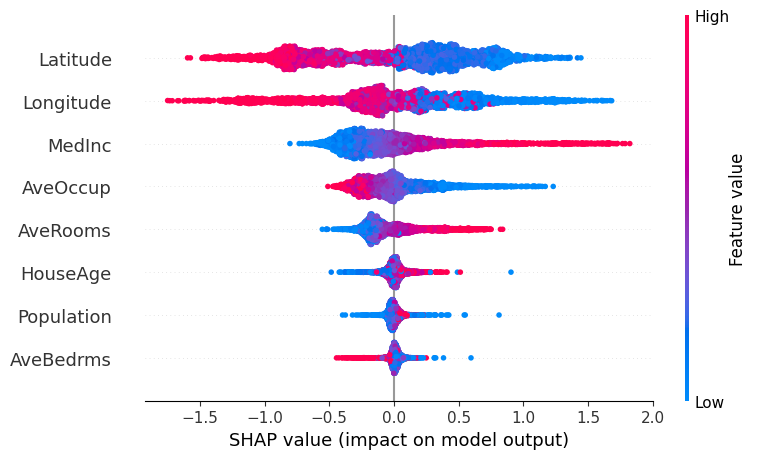

In [13]:
# Initialize the SHAP explainer for XGBoost
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
plt.show()

This plot is helps you understand how each feature contributes to the model's predictions. Here’s how to interpret the plot in detail:

1. **Feature Ranking (Y-axis):**  
   - **What You See:**  
     The y-axis lists the features, usually ordered by their overall importance. The feature at the top is considered the most influential in driving the predictions.
   - **What to Look For:**  
     Identify which features have the most spread (i.e., many dots spread out along the x-axis). These are the features that have the largest overall impact on the model’s output.

2. **SHAP Value Distribution (X-axis):**  
   - **What You See:**  
     The x-axis shows the SHAP values. Each dot represents an individual sample’s contribution from that feature to the prediction. A SHAP value quantifies how much a given feature pushes the model output above or below the base value (i.e., the average prediction).
   - **What to Look For:**  
     - **Direction of Impact:**  
       - Dots to the right (positive SHAP values) indicate that the feature is pushing the prediction higher.
       - Dots to the left (negative SHAP values) indicate that the feature is pushing the prediction lower.
     - **Magnitude of Effect:**  
       The further the dots are from zero, the stronger the impact of that feature on the prediction. Features with a wide spread are having a larger influence on the model’s output.

3. **Color Coding (Feature Value):**  
   - **What You See:**  
     Each dot is colored based on the actual value of the feature for that sample. Typically, a color gradient is used (e.g., blue for low values and red for high values).
   - **What to Look For:**  
     - **Correlation Between Feature Value and Impact:**  
       Notice if the color distribution aligns with the SHAP values. For example:
       - If red dots (high feature values) cluster on the right side, it suggests that higher values of the feature are associated with higher predictions.
       - Conversely, if red dots are mostly on the left, high values might be decreasing the prediction.
     - **Non-linear Effects:**  
       The spread and pattern of colors can indicate if the relationship between the feature value and its impact is linear or if there’s a more complex pattern at play.

4. **Density of Points:**  
   - **What You See:**  
     The concentration of dots in certain areas indicates how common certain impact levels are for each feature.
   - **What to Look For:**  
     - Areas with many overlapping dots suggest that for many samples, the feature contributes similarly to the prediction.
     - Sparse regions or outlier dots might indicate unusual or extreme behavior for a few samples, which could be worth investigating further.

5. **Overall Patterns and Model Insights:**  
   - **What to Look For:**  
     - **Important Features:**  
       The features at the top with a wide spread in SHAP values are key drivers of the model’s predictions.
     - **Feature Effects:**  
       Look at how different ranges of feature values (indicated by the color) affect the model output. This can give you insights into the nature of the relationship (positive, negative, or non-linear).
     - **Interaction Possibilities:**  
       While the summary plot doesn’t show interactions explicitly, if you see a very wide spread for a feature, it might be interacting with other features. In such cases, further analysis using SHAP interaction values can be insightful.

### Summary

In essence, the SHAP summary plot helps you:
- **Rank features by importance.**
- **Understand how individual feature values influence model predictions.**
- **Detect patterns such as consistent increases or decreases in predictions based on high or low feature values.**

## 9. Concluding Remarks
### Key Takeaways:
- **Gradient Boosting Models (XGBoost, LightGBM):** Highly accurate and robust. 
  - Use XGBoost when you have small-to-medium datasets, need robustness, and can invest in hyperparameter tuning.
  - Use LightGBM when dealing with large datasets or when you need fast training and built-in support for categorical features.

- **Baseline Models:** Linear regression and random forests can be strong baselines. Always compare against them.

- **Advanced Techniques:** Early stopping, hyperparameter tuning, and model interpretation (SHAP) are critical in building production-grade models.

### When to Choose Gradient Boosting Over Other Methods:
- When you require high predictive performance and can afford the computational cost.
- When model interpretability (via SHAP or feature importance) is necessary.
- For tasks where boosting methods have demonstrated state-of-the-art performance (e.g., Kaggle competitions).
